# To the average person in the world:
# You aren't going to get sick eating in or eating out, and your fear is irrational.

Foodborne illnesses and plane crashes have a lot in common: they are rare and they won't happen to you, but we know what happens in the media when that rare thing happens: sensationalism and fear sell.

I've been in the restaurant biz for a 30 years and I've seen all kinds of daily food preparation mistakes, and I've never been working during a foodborne illness outbreak.

Yet we are constantly looking at our food in a restaurant for chicken that's undercooked, but never think about the worker that rubbed his hands on his contaminated apron, or his hair, or picked his nose, or accidentally sprayed a degreaser near and accidentally on the burger that wound up in your mouth, or went to the bathroom and washed their hands for 5 seconds with no soap. I can tell you water doesn't get hot in 5 seconds and being high and rubbing some soap around for 5 seconds does not not kill squat.

My favorite comment from a guest claiming to be sick from eating at a restaurant is: "I was throwing up after eating your salad an hour ago."

That may be true, but it probably wasn't from the salad, and it definitely wasn't from an hour ago,  because if a batch of salad was bad, the calls would be flooding in, not just affecting one person after selling hundreds of them, and it much longer than an hour to get sick.

Society is very conscientious about sanitation and rightfully so, but evolution has given the human body quite the defense system against germs. We are at the top of the food chain after all.

Let's look at some data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
from itertools import permutations

In [2]:
states = {'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Washington DC',
          'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
          'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
          'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
          'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
          'Wisconsin', 'Wyoming'}

We are going to use the state populations from the 2010 consensus because it's the one most centered in the foodborn illness dataset.

And I'll clean it up after importing it.

In [3]:
# populations 2010 used for ease in this exercise and it lies in the middleish of the foodborne set
df_populations_2010 = pd.read_html('https://en.wikipedia.org/wiki/2010_United_States_census#State_rankings')[3]
pop_list = df_populations_2010.columns.to_list()
df_populations_2010.drop(['Rank', 'Population as of 2000 census', 'Change', 'Percent change'], axis=1, inplace=True)
df_populations_2010.rename(columns={'Population as of 2010 census[48]': 'Population'}, inplace=True)
df_populations_2010.drop(index=51, inplace=True)
df_populations_2010.at[49, 'State'] = 'Washington DC'
df_populations_2010.set_index('State', inplace=True)
df_populations_2010.head()

,Population
State,
California,37253956
Texas,25145561
New York,19378102
Florida,18801310
Illinois,12830632


Now the dataset for foodborne illness outbreaks by state from 1998 to 2015 and it's cleaned up too.

In [4]:
# foodborne illnesses 1998 to 2015
source = "https://www.kaggle.com/datasets/cdc/foodborne-diseases"
df_illness = pd.read_csv('outbreaks.csv')

# clean it up
df_illness.drop(
		['Location', 'Food', 'Serotype/Genotype', 'Species', 'Ingredient', 'Status'],
		inplace=True, axis=1)

df_illness.fillna(0, axis=1, inplace=True)

# only want actual states
US_states_only = list(set(df_illness.State.to_list()) - states)
US_states_territories = [df_illness.State.where(df_illness.State == _).dropna().index.tolist() for _ in
                         US_states_only]

for i in US_states_territories:
	for j in i:
		df_illness.drop(j, axis=0, inplace=True)
df_illness.head()

,Year,Month,State,Illnesses,Hospitalizations,Fatalities
0,1998,January,California,20,0.0,0.0
1,1998,January,California,112,0.0,0.0
2,1998,January,California,35,0.0,0.0
3,1998,January,California,4,0.0,0.0
4,1998,January,California,26,3.0,0.0


Just eyeballing this set shows alot of zeros in hospitalilizations and fatalities. Not a lot of Illnesses either.

Let's sort by deaths.

In [5]:
# get some general ideas for the US
all_deaths_notEqual_zero = df_illness.query('Fatalities != 0').sort_values(by=['Fatalities'], ascending=False, axis=0)
all_deaths_notEqual_zero

,Year,Month,State,Illnesses,Hospitalizations,Fatalities
6662,2003,January,Florida,7,0,7.0
7941,2004,February,Pennsylvania,22,0.0,6.0
14128,2010,January,Texas,10,10.0,5.0
16376,2012,November,California,6,6.0,4.0
5177,2001,November,Texas,404,0.0,4.0
...,...,...,...,...,...,...
7457,2003,October,California,16,10.0,1.0
7398,2003,September,Georgia,41,3.0,1.0
7286,2003,August,California,3,0,1.0
7117,2003,June,Georgia,31,5.0,1.0


Seven deaths in 2003 in January.

Let's see some sums.

In [6]:
all_deaths_total_number = df_illness.Fatalities.sum()
all_illness_number = df_illness.Illnesses.sum()
print(all_deaths_total_number)
print('#######################')
print(all_illness_number)

187.0
#######################
347827


Total deaths 187 in 17 years.
347827 hospitalizations in those years.
Out of how many people?

In [7]:
print(df_populations_2010.sum())
print((all_deaths_total_number/df_populations_2010.sum()))

Population    308745538
dtype: int64
Population    6.056768e-07
dtype: float64


308ish million people eating every year, 3 meals a day, and the death rate is 0.0000006
That's compelling evidence.

Let's take a look at states and remember these numbers are over 17 years.

In [8]:
# get some general ideas for the states
state_illnesses = df_illness.groupby(['State'])['Illnesses'].sum()
state_deaths = df_illness.groupby(['State'])['Fatalities'].sum()

# get some things  together
df_master = pd.concat([df_populations_2010, state_illnesses, state_deaths], axis=1)
df_master.sort_values(by=['Population'], ascending=False, axis=0, inplace=True)
df_master.head()

,Population,Illnesses,Fatalities
State,,,
California,37253956,39992,26.0
Texas,25145561,14187,14.0
New York,19378102,17407,12.0
Florida,18801310,23050,23.0
Illinois,12830632,24700,5.0


How about the rate of illness and deaths attached to the dataframe.

In [9]:
# get some percentages
df_master['sick_by_pop'] = df_master['Illnesses'] / df_master['Population']
df_master['dead_by_pop'] = df_master['Fatalities'] / df_master['Population']
df_master

,Population,Illnesses,Fatalities,sick_by_pop,dead_by_pop
State,,,,,
California,37253956,39992,26.0,0.001073,0.000001
Texas,25145561,14187,14.0,0.000564,0.000001
New York,19378102,17407,12.0,0.000898,0.000001
Florida,18801310,23050,23.0,0.001226,0.000001
Illinois,12830632,24700,5.0,0.001925,0.0
Pennsylvania,12702379,11374,9.0,0.000895,0.000001
Ohio,11536504,20451,8.0,0.001773,0.000001
Michigan,9883640,14471,5.0,0.001464,0.000001
Georgia,9687653,10070,5.0,0.001039,0.000001


See, this won't happen to you.
And a lot of people think they "may win the lottery" and a lot of people think "they could get sick eating food that the cooks spit in because they sent it back."

But they won't win or get sick even if they drink a meth head's spit.

And although I'm colorblind and prefer pure numbers you probably do like visualizations and since this is a storytelling mini-project, let's prepare for tsunami of seaborn.

In [10]:
master_cols = df_master.columns.to_list()  # [Population, Illness, Fatality, sick_by_pop, dead_by_pop]
reversed_master_cols = reversed(master_cols)  # ['dead_by_pop', 'sick_by_pop', 'Fatalities', 'Illnesses', 'Population']
relkind = ['scatter', 'line']
diskind = ['hist', 'kde']

perm_iter = list(permutations(master_cols, 2))

In [12]:
for i in perm_iter[::-1]:
	if i[1] == 'Population':
		perm_iter.remove(i)
for n in perm_iter[:0:-1]:
	if n[1] == 'Illnesses':
		perm_iter.remove(n)
for m in perm_iter[:8:-1]:
	if m[1] == 'Fatalities':
		perm_iter.remove(m)
perm_iter.pop()
perm_iter

[('Population', 'Illnesses'),
 ('Population', 'Fatalities'),
 ('Population', 'sick_by_pop'),
 ('Population', 'dead_by_pop'),
 ('Illnesses', 'Fatalities'),
 ('Illnesses', 'sick_by_pop'),
 ('Illnesses', 'dead_by_pop'),
 ('Fatalities', 'sick_by_pop'),
 ('Fatalities', 'dead_by_pop')]

These numbers are huge on the population end and minuscule on the you-are-not-even-gonna-go-to-the-hospital-much-less-wind-up-dead-end, so I'm going to take the logarithm of the large numbers so it's easier to read. Just remember the numbers are really large.

In [ ]:
# Scaled the population, illness, and fatality columns for better reaablility
df_master_ = df_master.copy()
df_master_log = df_master.copy()

df_master_log['Population log'] = df_master_log['Population'].apply(lambda x: np.log(x))
df_master_['Population'] = df_master_log['Population log']

df_master_log['Illnesses log'] = df_master_log['Illnesses'].apply(lambda x: np.log(x))
df_master_['Illnesses'] = df_master_log['Illnesses log']

df_master_log['Fatalities log'] = df_master_log['Fatalities'].apply(lambda x: np.log(x))
df_master_['Fatalities'] = df_master_log['Fatalities log']

And let's look ar a line plot.

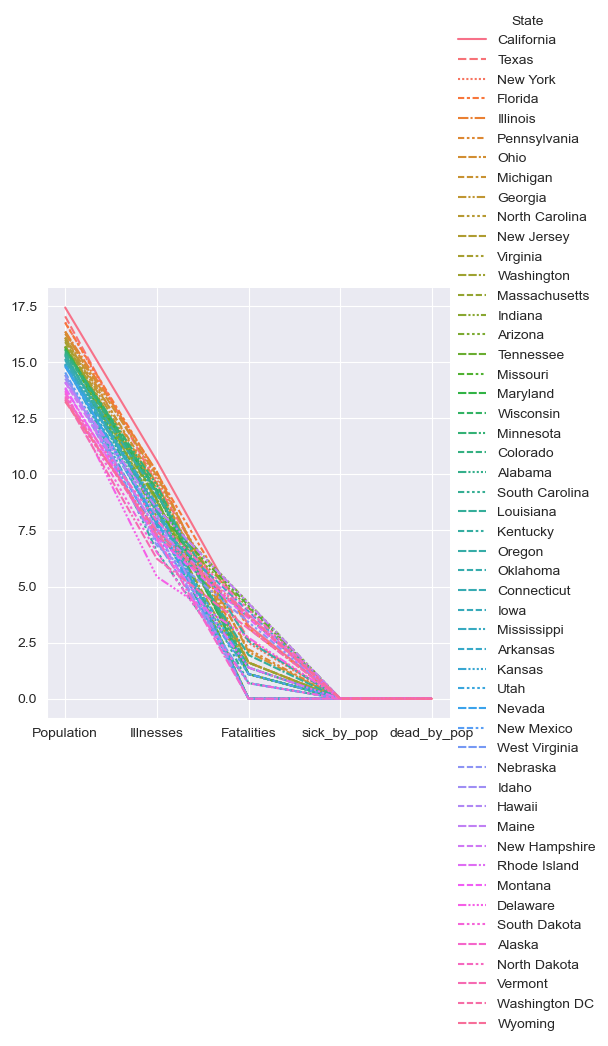

In [14]:
sns.relplot(data=df_master_.T, kind=relkind[1])

Find your state (good luck) but the over all picture says this, your population is huge, the odds of getting sick is super small, and dying is super, super, super small.

Here is some permutation anmd iterations fun.

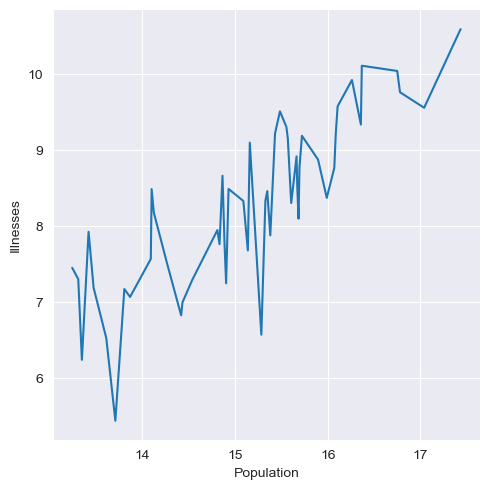

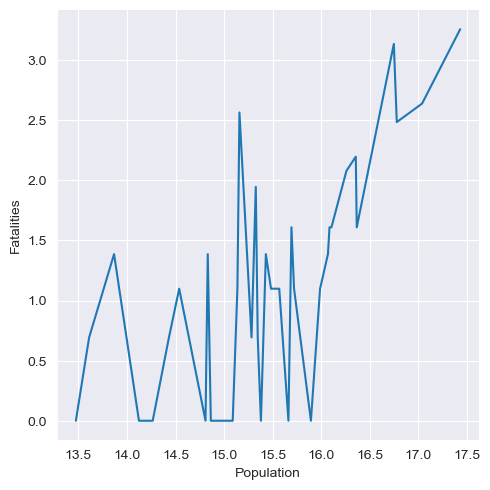

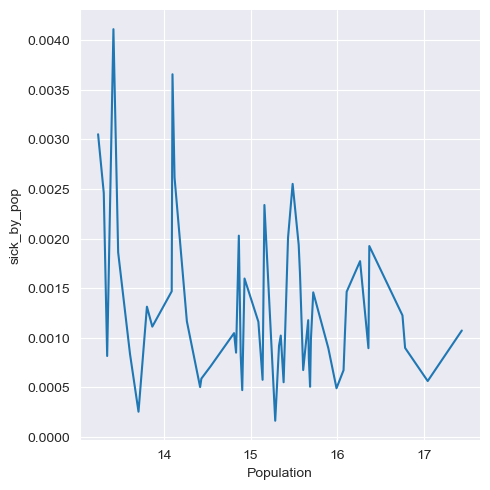

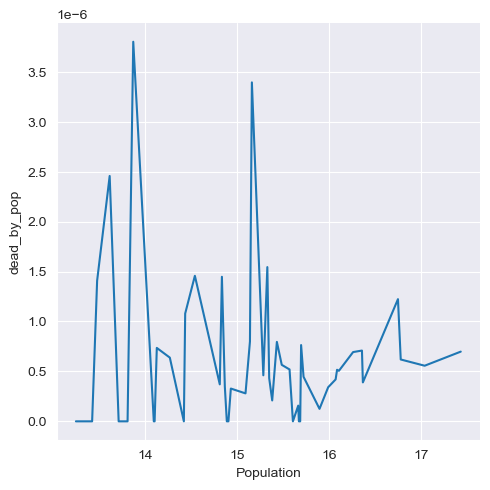

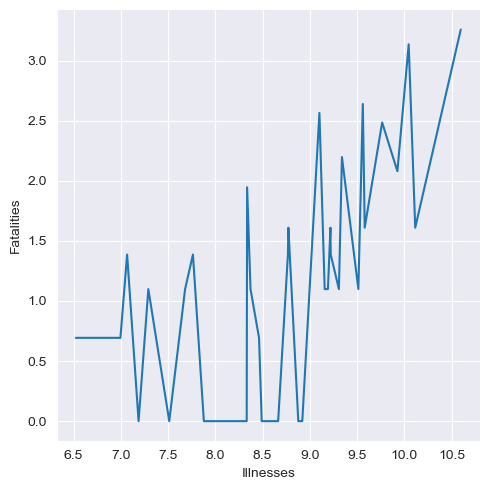

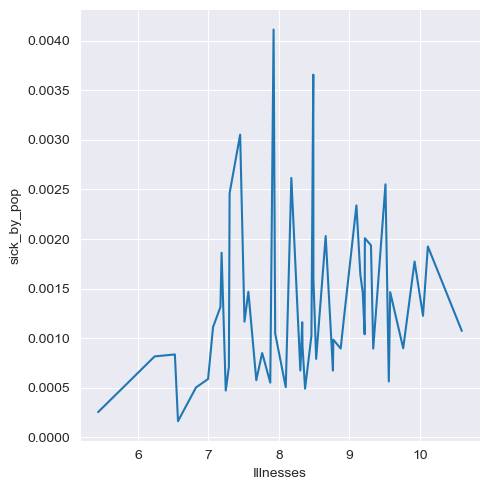

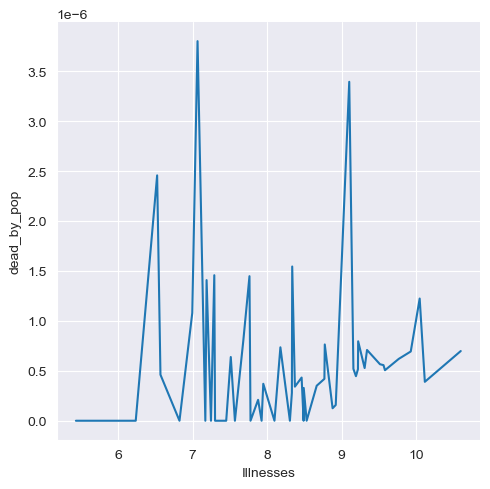

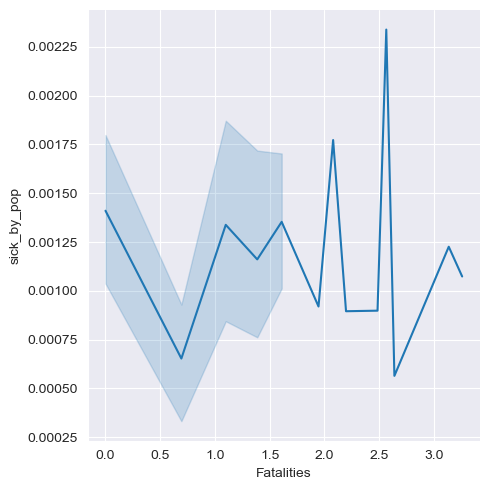

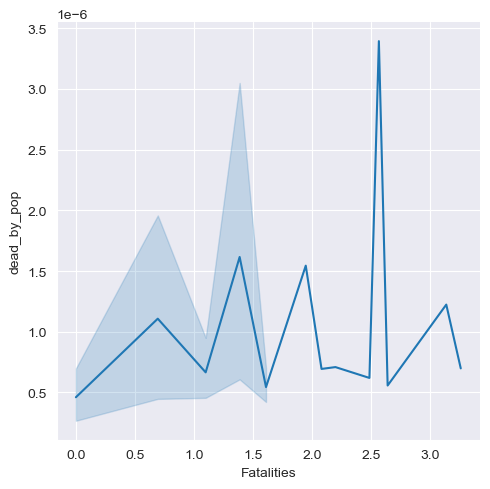

In [15]:
for i, j in perm_iter:
	sns.relplot(data=df_master_, x=i, y=j, kind=relkind[1])

The first 2 say there is a linear relationship between population and illness or death.
Well, duh!
And the next two show isn't happening to you. The spikes were probably legit outbreaks in some states not dependent on the state. In other words, it was rare and still didn't affect hardly anyone in the state.

Below is the kernal density functions. The highest probability is the central circle. The fourth one is the most interseting. It shows that if you population is middle of the pack, the probability that you die is, well, basically zero.

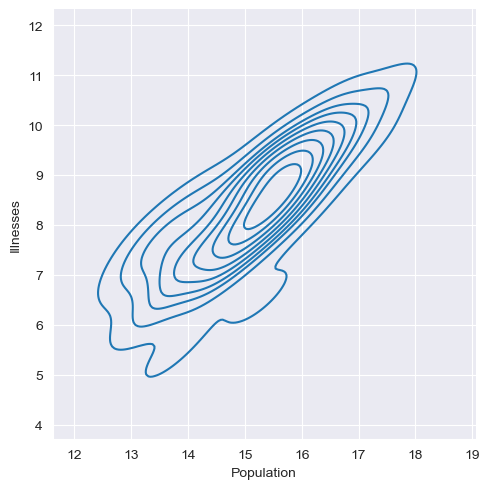

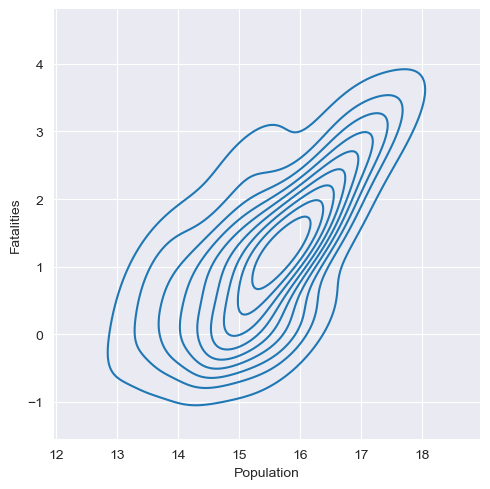

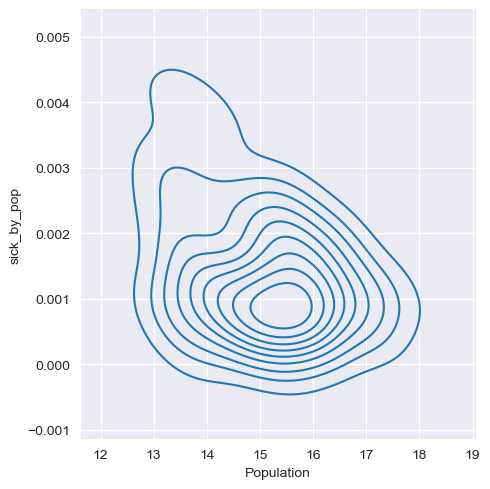

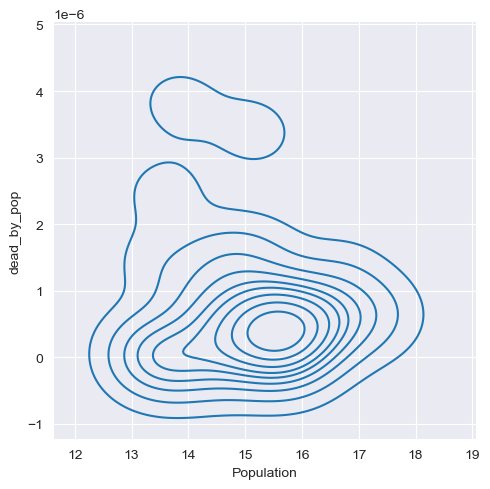

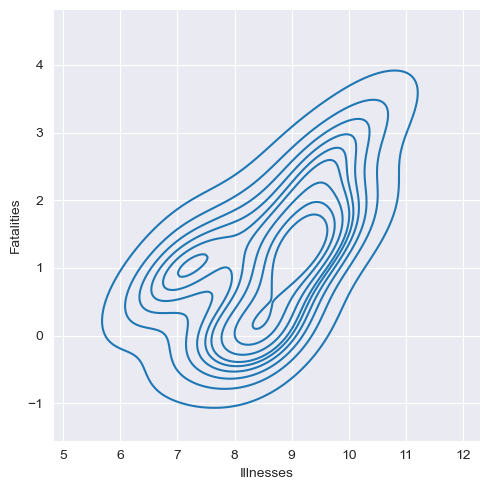

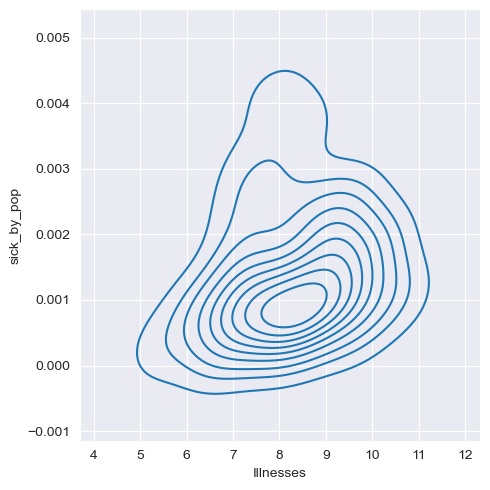

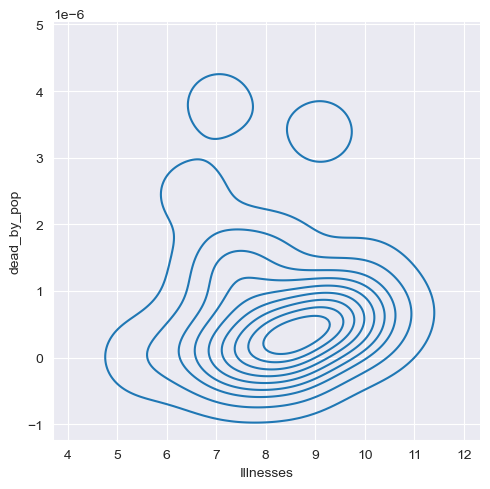

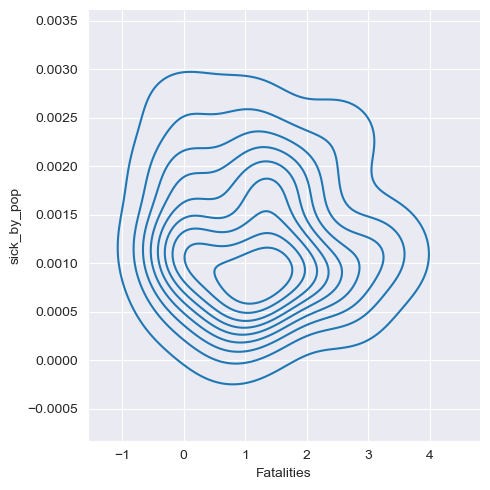

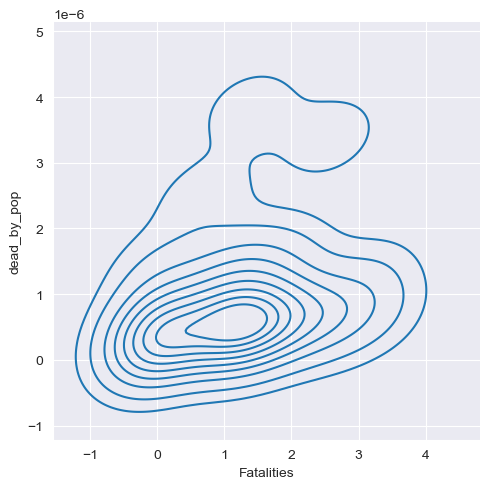

In [16]:
for i, j in perm_iter:
	sns.displot(data=df_master_, x=i, y=j, kind=diskind[1])

In this next one, for God's sake, the Fatalities box and whisker is all outliers!!
Doesn't this mean there is no mean?
Is this statistically impossible?
LOL!


/Users/jshensley/Desktop/conda_envs/foodbourne/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<AxesSubplot: >

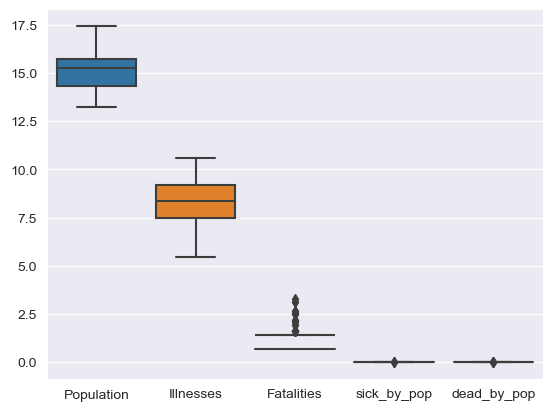

In [17]:
sns.boxplot(data=df_master_)

The next one is just checking off the it-looks-cool-but-you-still-ain't-getting-sick-or-going-to-the-hospital visualization box.

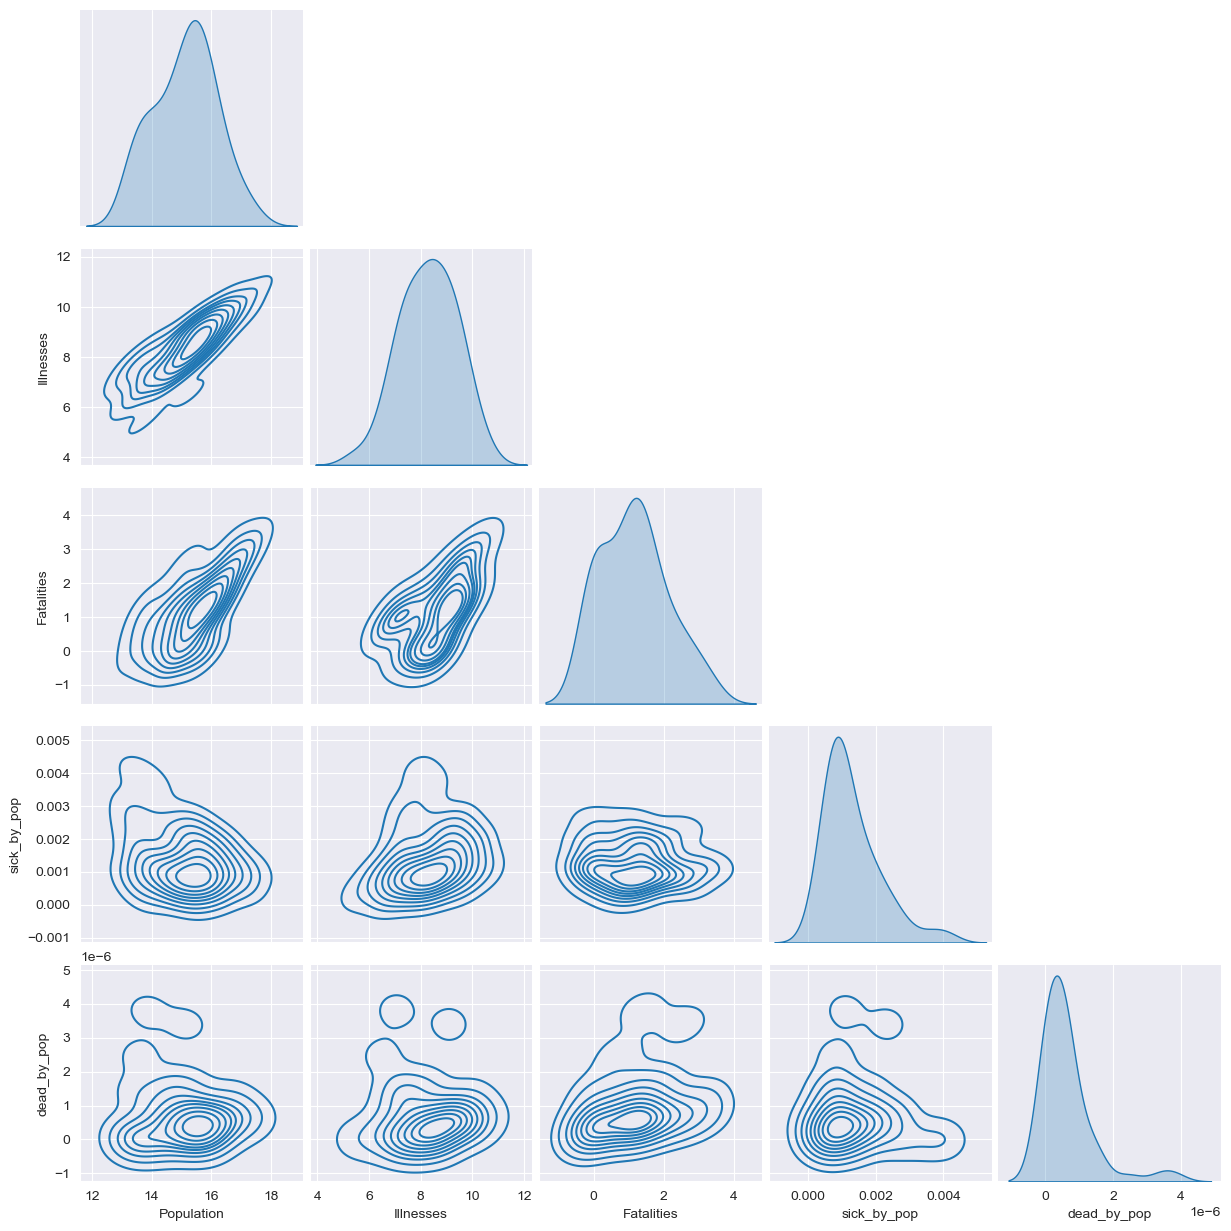

In [18]:
sns.pairplot(data=df_master_, corner=True, kind='kde')

Let's add the number of meals in the year (based on 3 meals a day) and take the log to make it more digestible.

In [23]:
# based on 3 meals a day
df_master_["Meals served"] = df_master['Population'] * 3
df_master_["Meals served"] = df_master_["Meals served"].apply(lambda x: np.log(x))
df_master_ = df_master_.iloc[:,[0,5,1,2,3,4]]
df_master_.head()

,Population,Illnesses,Fatalities,sick_by_pop,dead_by_pop,Meals served
State,,,,,,
California,17.433269,10.596435,3.258097,0.001073,0.000001,18.531881
Texas,17.040192,9.560081,2.639057,0.000564,0.000001,18.138804
New York,16.779654,9.764628,2.484907,0.000898,0.000001,17.878267
Florida,16.749437,10.045421,3.135494,0.001226,0.000001,17.848049
Illinois,16.367346,10.114559,1.609438,0.001925,0.0,17.465958


And if you fall in the "Meals served" box, you can see you still are not dying.

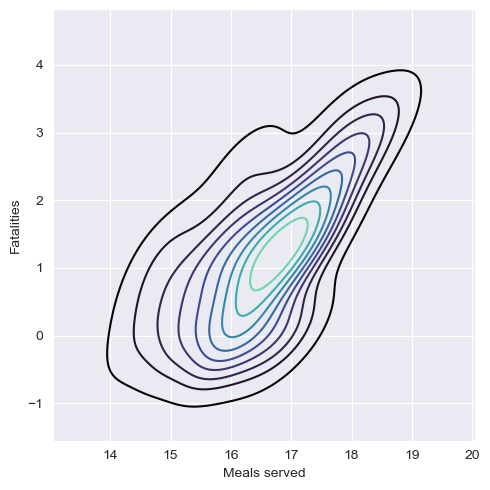

In [25]:
sns.displot(data=df_master_, x='Meals served', y='Fatalities', kind='kde', cmap='mako')

But for fun, let's "unlog" it and see the probability you die eating a meal.

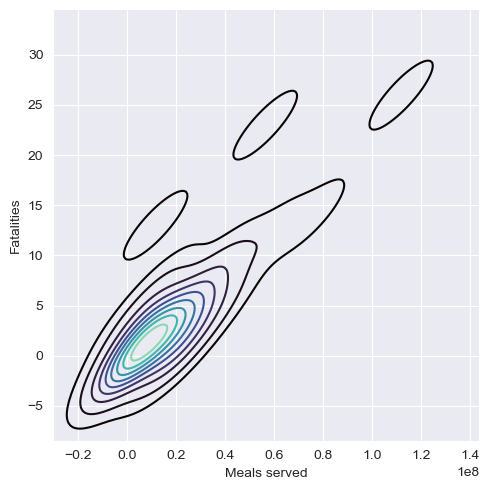

In [28]:
df_master['Meals served'] = df_master['Population']*3
sns.displot(data=df_master, x='Meals served', y='Fatalities', kind='kde', cmap='mako')

So when the meals served are about 120,000,000, there is a small probability you die, otherwise, you ain't.